In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [76]:
# Network Parameters
num_input = 6
timesteps = 100 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [77]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction
    
#     print("for ", i, " window_y size is ", len(window_y))
    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
#             print('start and end time : ', start_time, ", ", end_time)
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [78]:
data_x_seq, data_y_seq = add_data(1, 1, '1L', 'GD')
print(len(data_y_seq))
print([len(i) for i in data_y_seq])
print(sum([len(i) for i in data_y_seq]))
# print(data_y_seq)

4
[51, 114, 907, 53]
1125


In [79]:
step_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'WC'])
    step_data_list.append([i, 1, '2R', 'WC'])
    step_data_list.append([i, 2, '1L', 'WC'])
    step_data_list.append([i, 2, '2R', 'WC'])
    
    step_data_list.append([i, 3, '1L', 'WC'])
    step_data_list.append([i, 3, '2R', 'WC'])
    step_data_list.append([i, 5, '1L', 'WC'])
    step_data_list.append([i, 5, '2R', 'WC'])
    
    
    step_data_list.append([i, 6, '1L', 'WC'])
    step_data_list.append([i, 6, '2R', 'WC'])
    step_data_list.append([i, 7, '1L', 'WC'])
    step_data_list.append([i, 7, '2R', 'WC'])
    step_data_list.append([i, 8, '1L', 'WC'])
    step_data_list.append([i, 8, '2R', 'WC'])   

step_data_list.append([7, 9, '1L', 'WC'])
step_data_list.append([8, 9, '1L', 'WC'])
step_data_list.append([9, 10, '1L', 'WC'])
step_data_list.append([10, 10, '1L', 'WC'])                          

step_data_list.append([7, 9, '2R', 'WC'])
step_data_list.append([8, 9, '2R', 'WC'])
step_data_list.append([9, 10, '2R', 'WC'])
step_data_list.append([10, 10, '2R', 'WC'])

step_data_list.remove([4, 6, '2R', 'WC'])
print(step_data_list)

[[1, 1, '1L', 'WC'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [1, 8, '1L', 'WC'], [1, 8, '2R', 'WC'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [2, 8, '1L', 'WC'], [2, 8, '2R', 'WC'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [3, 8, '1L', 'WC'], [3, 8, '2R', 'WC'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'],

In [80]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

219766
219766


In [81]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

219766


In [82]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'WC'])
    step_test_list.append([i, 1, '2R', 'WC'])
    step_test_list.append([i, 2, '1L', 'WC'])
    step_test_list.append([i, 2, '2R', 'WC'])
    
    step_test_list.append([i, 3, '1L', 'WC'])
    step_test_list.append([i, 3, '2R', 'WC'])
    step_test_list.append([i, 5, '1L', 'WC'])
    step_test_list.append([i, 5, '2R', 'WC'])
    
    
    step_test_list.append([i, 6, '1L', 'WC'])
    step_test_list.append([i, 6, '2R', 'WC'])
    step_test_list.append([i, 7, '1L', 'WC'])
    step_test_list.append([i, 7, '2R', 'WC'])
    step_test_list.append([i, 8, '1L', 'WC'])
    step_test_list.append([i, 8, '2R', 'WC'])  
      
print(step_test_list)

[[6, 1, '1L', 'WC'], [6, 1, '2R', 'WC'], [6, 2, '1L', 'WC'], [6, 2, '2R', 'WC'], [6, 3, '1L', 'WC'], [6, 3, '2R', 'WC'], [6, 5, '1L', 'WC'], [6, 5, '2R', 'WC'], [6, 6, '1L', 'WC'], [6, 6, '2R', 'WC'], [6, 7, '1L', 'WC'], [6, 7, '2R', 'WC'], [6, 8, '1L', 'WC'], [6, 8, '2R', 'WC']]


In [83]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

40
40
[859, 1605, 4, 859, 1605, 4, 9, 972, 1460, 34, 9, 972, 1460, 34, 31, 657, 1234, 31, 657, 1234, 711, 1402, 711, 1402, 21, 675, 1282, 21, 675, 1282, 724, 1286, 2, 724, 1286, 2, 778, 1355, 778, 1355]


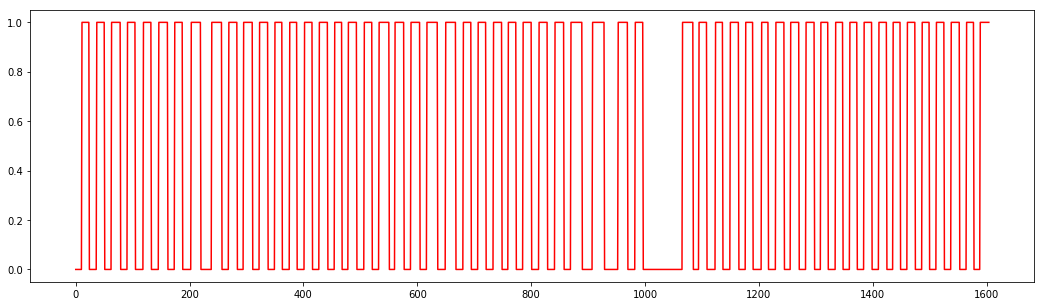

In [84]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [85]:
NUM_LAYERS=2

def LstmCell():
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
#     return lstm_cell
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
# with graph.as_default(), tf.device('/gpu:0'):
with graph.as_default(), tf.device('/cpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [86]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

219766
219766


In [87]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

220022


In [88]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [89]:
training_steps = 2001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-time40.ckpt-2000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 100 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-time100.ckpt', global_step=step)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

Initialized
Loss at step 0: 0.578647, train accuarcy : 0.500000
Loss at step 100: 0.244090, train accuarcy : 0.628906
Loss at step 200: 0.167179, train accuarcy : 0.777344
Loss at step 300: 0.160257, train accuarcy : 0.789062
Loss at step 400: 0.162903, train accuarcy : 0.769531
Loss at step 500: 0.146768, train accuarcy : 0.789062
Loss at step 600: 0.134677, train accuarcy : 0.789062
Loss at step 700: 0.128921, train accuarcy : 0.832031
Loss at step 800: 0.132743, train accuarcy : 0.828125
Loss at step 900: 0.115272, train accuarcy : 0.828125
Loss at step 1000: 0.132244, train accuarcy : 0.832031
Loss at step 1100: 0.131418, train accuarcy : 0.824219
Loss at step 1200: 0.105205, train accuarcy : 0.859375
Loss at step 1300: 0.121848, train accuarcy : 0.851562
Loss at step 1400: 0.123291, train accuarcy : 0.812500
Loss at step 1500: 0.088668, train accuarcy : 0.894531
Loss at step 1600: 0.096456, train accuarcy : 0.890625
Loss at step 1700: 0.087021, train accuarcy : 0.898438
Loss at st

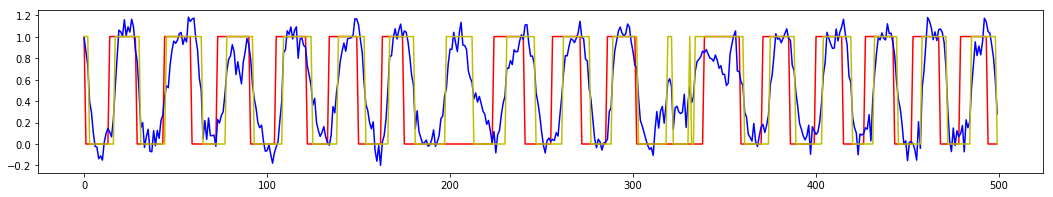

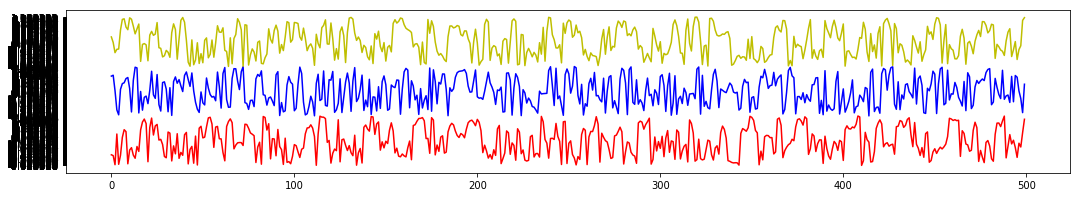

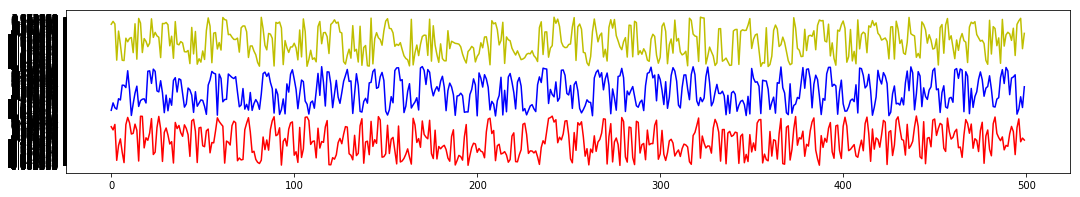

In [92]:
plt.figure(figsize=(18, 3))
good=10
bad=5
start= 0
end = 500
index = 3
plt.plot([i[0] for i in test_y[index][start:end]], 'r')
plt.plot([i[0] for i in test_logits[index][start:end]], 'b')
plt.plot([round(i[0]) for i in test_logits[index][start:end]], 'y')
plt.show()

#rotationRateX,rotationRateY,rotationRateZ,
#userAccelerationX,userAccelerationY,userAccelerationZ
plt.figure(figsize=(18, 3))
plt.plot([i[-1][0] for i in test_x[index][start:end]], 'r')
plt.plot([i[-1][1] for i in test_x[index][start:end]], 'b')
plt.plot([i[-1][2] for i in test_x[index][start:end]], 'y')
plt.show()

plt.figure(figsize=(18, 3))
plt.plot([i[-1][3] for i in test_x[index][start:end]], 'r')
plt.plot([i[-1][4] for i in test_x[index][start:end]], 'b')
plt.plot([i[-1][5] for i in test_x[index][start:end]], 'y')
plt.show()

In [91]:
test_loss_large = [test_loss[i] for i in range(len(test_loss)) if len(test_y[i])>100]
print(test_loss_large)
print(test_loss.index(min(test_loss_large)), min(test_loss_large))
print(test_loss.index(max(test_loss_large)), max(test_loss_large))

[0.09873955, 0.09119124, 0.23801981, 0.21565948, 0.12646353, 0.064203508, 0.13614918, 0.069051236, 0.093388848, 0.090634204, 0.077475317, 0.068392985, 0.085498385, 0.089596517, 0.085128218, 0.090170637, 0.079307146, 0.084181301, 0.067449123, 0.072351605, 0.085245818, 0.10307142, 0.081660777, 0.079809874, 0.068999112, 0.12313173, 0.064030476, 0.11300804]
38 0.0640305
3 0.23802


In [93]:
print("test loss : ", test_loss)
print(len(test_loss))
print(test_loss.index(min(test_loss)), min(test_loss))
print(test_loss.index(max(test_loss)), max(test_loss))

test loss :  [0.09873955, 0.09119124, 0.098628223, 0.23801981, 0.21565948, 0.003328579, 0.30870742, 0.12646353, 0.064203508, 0.098923907, 0.069021955, 0.13614918, 0.069051236, 0.16812658, 0.13182752, 0.093388848, 0.090634204, 0.1458995, 0.077475317, 0.068392985, 0.085498385, 0.089596517, 0.085128218, 0.090170637, 0.075375259, 0.079307146, 0.084181301, 0.058220156, 0.067449123, 0.072351605, 0.085245818, 0.10307142, 0.035910305, 0.081660777, 0.079809874, 0.0031292406, 0.068999112, 0.12313173, 0.064030476, 0.11300804]
40
35 0.00312924
6 0.308707


In [94]:
test_logits_bin = []
for t in test_logits:
    test_logits_part = [[round(i[0])] for i in t]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin.append(test_logits_part)

count = 0
total = 0
for i in range(0, len(test_x)):
    total += len(test_y[i])
    for j in range(0, len(test_y[i])):
        if(test_y[i][j][0] == test_logits_bin[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

26189
30202
test accuarcy :  0.8671280047678962


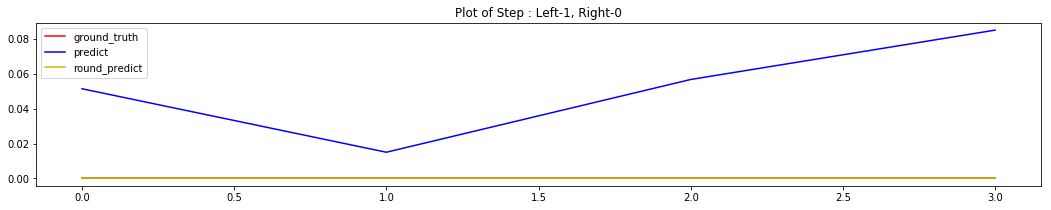

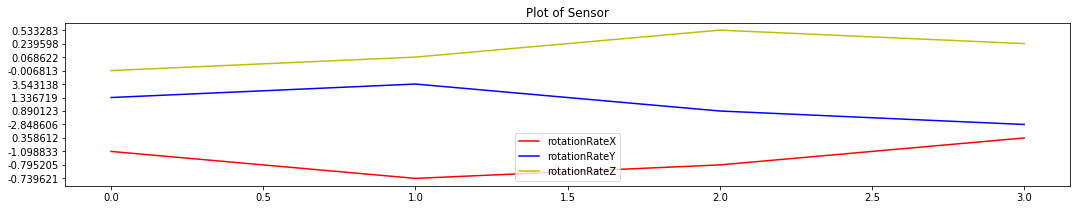

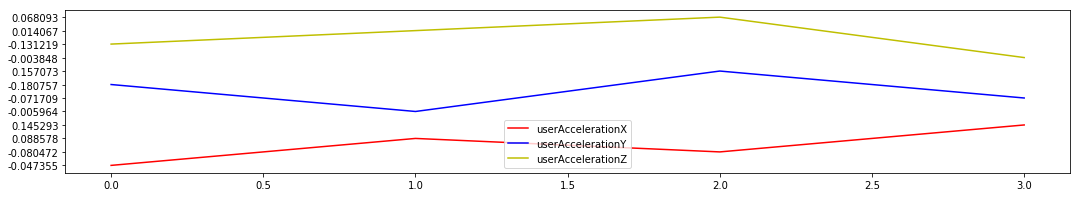

In [95]:
good=10
bad=5
index = bad

start= 0
end = len(test_x[index])
# end = 170

plt.figure(figsize=(18, 3))
plt.title('Plot of Step : Left-1, Right-0')
plt.plot([i[0] for i in test_y[index][start:end]], 'r', label='ground_truth')
plt.plot([i[0] for i in test_logits[index][start:end]], 'b', label='predict')
plt.plot([i[0] for i in test_logits_bin[index][start:end]], 'y', label='round_predict')
plt.legend()
plt.show()

#rotationRateX,rotationRateY,rotationRateZ,
plt.figure(figsize=(18, 3))
plt.title('Plot of Sensor')
plt.plot([i[-1][0] for i in test_x[index][start:end]], 'r', label='rotationRateX')
plt.plot([i[-1][1] for i in test_x[index][start:end]], 'b', label='rotationRateY')
plt.plot([i[-1][2] for i in test_x[index][start:end]], 'y', label='rotationRateZ')
plt.legend()
plt.show()

#userAccelerationX,userAccelerationY,userAccelerationZ
plt.figure(figsize=(18, 3))
plt.plot([i[-1][3] for i in test_x[index][start:end]], 'r', label='userAccelerationX')
plt.plot([i[-1][4] for i in test_x[index][start:end]], 'b', label='userAccelerationY')
plt.plot([i[-1][5] for i in test_x[index][start:end]], 'y', label='userAccelerationZ')
plt.legend()
plt.show()

In [96]:
#test_y      [[0], [0], [1]]
#test_logits 

step_time_actual, step_time_predict= [], []

for i in range(0, len(test_x)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(0, len(test_y[i])-1):
        if(abs(test_y[i][j][0]-test_y[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin[i][j][0]-test_logits_bin[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)

print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

[58, 112, 0, 58, 112, 0, 2, 50, 90, 2, 2, 50, 90, 2, 2, 48, 94, 2, 48, 94, 46, 92, 46, 92, 2, 50, 97, 2, 50, 97, 56, 102, 0, 56, 102, 0, 50, 90, 50, 90]
[62, 115, 1, 62, 118, 0, 0, 62, 90, 2, 2, 60, 90, 2, 2, 50, 96, 4, 50, 96, 48, 91, 47, 92, 2, 50, 96, 2, 50, 96, 58, 102, 0, 56, 104, 0, 50, 94, 50, 94]


In [97]:
print(step_time_actual[0])
print(step_time_predict[0])

[0, 1, 14, 29, 44, 59, 73, 91, 105, 122, 134, 150, 163, 175, 224, 241, 256, 272, 286, 302, 339, 359, 371, 386, 400, 415, 427, 443, 453, 468, 479, 494, 507, 520, 532, 546, 561, 574, 587, 601, 613, 629, 641, 654, 666, 677, 692, 707, 719, 734, 747, 762, 775, 791, 804, 820, 832, 847]
[0, 1, 14, 31, 44, 61, 74, 92, 105, 122, 135, 151, 163, 178, 194, 217, 229, 244, 261, 274, 285, 302, 315, 321, 338, 360, 370, 387, 400, 414, 428, 444, 456, 470, 482, 496, 508, 522, 534, 548, 560, 575, 588, 603, 615, 629, 641, 656, 668, 679, 693, 708, 720, 735, 748, 764, 777, 791, 804, 820, 834, 849]


In [98]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric1_overcount = 0
metric2_overcount = 0

metric1_undercount_list = []
metric2_undercount_list = []
metric1_overcount_list = []
metric2_overcount_list = []

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    
    metric1_undercount += undercount
    metric1_undercount_list.append(undercount*1.0/(len(step_time_actual[i])-1))
    metric1_overcount += overcount
    metric1_overcount_list.append(overcount*1.0/(len(step_time_actual[i])-1))
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")
    if(diff==0):
        metric2_undercount_list.append(-diff*1.0/(len(step_time_actual[i])-1))
        metric2_overcount_list.append(diff*1.0/(len(step_time_actual[i])-1))
    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric2_undercount -= diff
        metric2_undercount_list.append(-diff*1.0/(len(step_time_actual[i])-1))
    if(diff>0):
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric2_overcount += diff
        metric2_overcount_list.append(diff*1.0/(len(step_time_actual[i])-1))

print("total undercount metric 1 : \n", metric1_undercount_list)
print("total overcount metric 1 : \n", metric1_overcount_list)
print("total undercount metric 2 : \n",metric2_undercount_list)
print("total overcount metric 2 : \n", metric2_overcount_list)

print('------------------')
print("total undercount metric 1 : ", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1 : ", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2 : ", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2 : ", metric2_overcount*1.0/total_step_count)

total undercount metric 1 : 
 [0.08771929824561403, 0.07207207207207207, -0.0, 0.017543859649122806, 0.02702702702702703, -0.0, 1.0, 0.16326530612244897, 0.2247191011235955, 0.0, 0.0, 0.22448979591836735, 0.2247191011235955, 0.0, 0.0, 0.06382978723404255, 0.043010752688172046, 1.0, 0.19148936170212766, 0.12903225806451613, 0.13333333333333333, 0.08791208791208792, 0.13333333333333333, 0.054945054945054944, 0.0, 0.22448979591836735, 0.2604166666666667, 1.0, 0.3469387755102041, 0.16666666666666666, 0.03636363636363636, 0.009900990099009901, -0.0, 0.01818181818181818, 0.019801980198019802, -0.0, 0.16326530612244897, 0.056179775280898875, 0.14285714285714285, 0.056179775280898875]
total overcount metric 1 : 
 [0.15789473684210525, 0.0990990990990991, -0.0, 0.08771929824561403, 0.08108108108108109, -0.0, 0.0, 0.3673469387755102, 0.2247191011235955, 0.0, 0.0, 0.3877551020408163, 0.23595505617977527, 0.0, 0.0, 0.10638297872340426, 0.06451612903225806, 0.0, 0.23404255319148937, 0.1505376344086